Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy (cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***. Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego różniczkowania funkcji (np. Tensorflow, pytorch, autograd). 

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz



# Wszystkie wnioski zapisywane są na bieżąco w komentarzach

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
from typing import Union, Tuple

class Model:
    """Klasyfikator - Regresja logistyczna.
    
    Parametry:
        learning_rate (float): Współczynnik uczenia.
        decay_rate (float): Współcznnik zmniejszania współczynnika uczenia.
        beta (float): Parametr momentum.
        regularization (boolean): Parametr decydujący o zastosowaniu regularyzacji L2.
        C (float) : Współczynnik regularyzacji (1 / lambda).
        shuffle (boolean): Parametr decydujący o przetasowywaniu danych przed każdą iteracją uczenia.
        epochs (int): Liczba iteracji uczenia.
        verbose (boolean): Parametr decydujący o wypisywaniu numeru iteracji i kosztu.
        random_state (int): Ziarno dla generatora liczb pseudolosowych.
        
    Atrybuty:
        w_ (array): Wektor wag.
        b_ (float): Bias (Nie udało mi się znaleźć dobrego, polskiego tłumaczenia :P).
        cost_ (array): Wartości funkcji kosztu.
    """
    def __init__(self, learning_rate: float = 0.001, decay_rate: float = 1 / 30, beta: float = 0.92,
                 regularization: bool = False, C: float = 10 ** 3, shuffle: bool = True,
                 epochs: int = 30, verbose: bool = False, random_state: int = None) -> None:
        """Inicjalizacja parametrów.
        
        Domyślne wartości parametrów:
            learning_rate: 0.01
            decay_rate: 0
            beta: 0.92
            regularization = False
            C = 1000
            shuffle: True
            epochs: 30
            verbose: False
            random_state: None
        """
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.beta = beta
        self.regularization = regularization
        if regularization:
            self.lambd = 1. / C
        else:
            self.lambd = 0
        self.shuffle = shuffle
        self.epochs = epochs
        self.verbose = verbose
        self.random_state = random_state
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Dopasowanie danych uczących.
        
        Parametry:
            X (array): Tablica próbek.
            y (array): Tablica etykiet.
        """
        self._init_params(X.shape[1])
        self.cost_ = []
        for epoch in range(self.epochs + 1):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            if self.decay_rate > 0:
                self.learning_rate *= 1. / (1. + self.decay_rate * self.learning_rate * epoch)
            cost = []
            for x, target in zip(X, y):
                cost.append(self._update(x, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
            if self.verbose:
                print('Epoch:', epoch, 'Cost:', '{:.3f}'.format(avg_cost))
    
    def _init_params(self, m: int) -> None:
        """Inicjalizacja wektora wag i bias.
        
        Inicjalizuje wektor wag i bias małymi wartościami z rozkładu normalnego
        wyśrodkowanego w zerze.
        
        Parametry:
            m (int): Rozmiar tablicy cech.
        """
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = self.rgen.normal(loc=0.0, scale=0.01, size=1)[0]
        
    def _update(self, x: np.ndarray, target: np.int32) -> np.float64:
        """Aktualizacja atrybutów.
        
        Aktualizuje wagi za pomocą algorytmu SGD z momentum oraz oblicza koszt.
        
        Parametry:
            x (array): Tablica cech.
            target (int): Wartość etykiety.
            
        Zwraca:
            Wartość kosztu.
        """
        output = self.sigmoid(self._input(x))
        dw, db = self._gradient(x, target)
        vw, vb = 0, 0
        vw = self.beta * vw + (1 - self.beta) * dw
        vb = self.beta * vb + (1 - self.beta) * db
        self.w_ -= self.learning_rate * vw
        self.b_ -= self.learning_rate * vb
        return self._loss(output, target)
    
    def _loss(self, output: np.float64, target: np.int32, eps: float = 1e-12) -> np.float64:
        """Funkcja kosztu logistycznego.
        
        Parametry:
            output (float): Wartość aktywacji.
            target (int): Wartość etykiety.
            
        Zwraca:
            Wartość kosztu.
        """
        #Do argumentu logarytmu dodaję bardzo małą wartość, by uniknąć sytuacji, gdzie pojawi się 0 jako argument
        #i logarytm wystrzeli w kosmos (a nawet w piekło, bo do -inf).
        return -target * np.log(output + eps) - (1 - target) * np.log(1 - output + eps) \
                + self.lambd / 2 * np.linalg.norm(self.w_) ** 2
    
    def _gradient(self, x: np.ndarray, target: np.float64, w: np.ndarray = None, b: np.float64 = None) -> Tuple[np.float64, np.float64]:
        """Obliczenie gradientu funkcji kosztu.
        
        Parametry:
            x (array): Tablica cech.
            target (int): Wartość etykiety.
            w (array): Wektor wag.
            b (float): Bias.
        
        Zwraca:
            Gradient funkcji kosztu ze względu na wektor wag oraz bias w postaci krotki.
        """
        output = self.sigmoid(self._input(x))
        dw = x * (output - target) + self.lambd * self.w_.T / np.linalg.norm(self.w_)
        db = output - target
        return dw, db
                
    
    def _shuffle(self, X, y):
        """Przetasowanie danych uczących.
        
        Parametry:
            X (array): Tablica próbek.
            y (int): Tablica etykiet.
        
        Zwraca:
            Przetasowane tablice próbek i etykiet w postaci krotki.
        """
        permutation = self.rgen.permutation(len(y))
        return X[permutation], y[permutation]
        
    def _input(self, X):
        return np.dot(X, self.w_) + self.b_

    def sigmoid(self, z):
        """Sigmoidalna funkcja aktywacji.
        
        Parametry:
            z (float): Dane wejściowe.
        
        Zwraca:
            Wartość funkcji aktywacji.
        """
        #Przy dużych wartościach learning rate exp uzyskuje zbyt duże wartości, stąd użycie np.clip.
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Przewidywanie.
        
        Parametry:
            X (array): Tablica próbek.
        
        Zwraca:
            Listę z przewidzianymi etykietami dla zbioru walidacyjnego. 
        """
        return np.where(self.sigmoid(self._input(X)) >= 0.5, 1, 0)

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray, confusion_matrix: bool = False) -> Union[float, Tuple[float, np.ndarray]]:
        """Obliczanie dokładności modelu.
        
        Parametry:
            y_true (array): Tablica prawdziwych etykiet.
            y_pred (array): Tablica przewidzianych etykiet.
            confusion_matrix (boolean): Parametr decydujący o zwróceniu macierzy pomyłek.
        
        Zwraca:
            Dokładność modelu lub, jeśli confusion_matrix == True, dokładność modelu i macierz pomyłek. 
        """
        #Zaimplementowałem współczynniki false_positive itd. na wypadek konieczności zwrócenia tablicy pomyłek.
        false_positive, false_negative, true_positive, true_negative = 0, 0, 0, 0
        for true, pred in zip(y_true, y_pred):
            if true == 1 and pred == 1:
                true_positive += 1
            elif true == 1 and pred == 0:
                false_negative += 1
            elif true == 0 and pred == 1:
                false_positive += 1
            elif true == 0 and pred == 0:
                true_negative += 1
        acc = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        conf = np.array([[true_positive, false_positive],
                         [false_negative, true_negative]])
        if confusion_matrix:
            return acc, conf
        else:
            return acc
        
def standardize(train: np.ndarray, test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Standaryzacja danych.
        
    Parametry:
        train (array): Tablica próbek uczących.
        test (array): Tablica próbek walidacyjnych.
        
    Zwraca:
        Krotkę ze standaryzowanymi wartościami cech.   
    """
    return (train - train.mean()) / train.std(), (test - test.mean()) / test.std()

def drop_values(values: np.ndarray, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Usunięcie wartości ze zbioru.
        
    Usuwa z przekazanego zbioru danych określone wartości.
        
    Parametry:
        train (array): Tablica próbek uczących.
        test (array): Tablica próbek walidacyjnych.
        
    Zwraca:
        Krotkę ze zbiorami danych bez danych wartości.   
    """
    condition = np.isin(y, values)
    drop_indices = [index for index, val in enumerate(condition) if val == True]
    X = np.delete(X, drop_indices, 0)
    y = np.delete(y, drop_indices)
    return X, y

def is_prime(value: np.uint8) -> bool:
    """Sprawdzenie, czy liczba jest pierwsza.
        
    Parametry:
        value (int): Liczba do sprawdzenia.
        
    Zwraca:
        Wartość logiczną True, jeżeli liczba jest pierwsza. W przeciwnym razie False.
       """
    for n in range(2, int(np.sqrt(value)) + 1):
        if value % n == 0:
            return False
    return True
    

In [51]:
#Wczytanie danych
X_train = idx2numpy.convert_from_file('train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
X_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte')

#Formatowanie tablic
n_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], n_pixels).astype('float64')
n_pixels = X_test.shape[1] * X_test.shape[2]
X_test = X_test.reshape(X_test.shape[0], n_pixels).astype('float64')

#Usuwanie 0 oraz 1
X_train, y_train = drop_values([0, 1], X_train, y_train)
X_test, y_test = drop_values([0, 1], X_test, y_test)

#Oznakowanie liczb ze względu na pierwszość
#Liczby pierwsze zostają oznakowane jako 1, a złożone jako 0.
y_train_prime = np.array([1 if is_prime(value) else 0 for value in y_train])
y_test_prime = np.array([1 if is_prime(value) else 0 for value in y_test])

#Standaryzacja
#W przypadku algorytmu SGD standaryzacja jest korzystna ze względu na szybsze uzyskiwanie zbieżności.
X_train, X_test = standardize(X_train, X_test)

In [ ]:
#Strojenie hiperparametrów
#Użyłem 25% zbioru uczącego, żeby wyrobić się w czasie. Na Intel Core i5-4690 3.50 GHz ten proces zajął około 2h.
#Przy 200 iteracjach i decay_rate 1/200 najwyższą dokładność (0.920) uzyskano przy learning_rate = 0.001 i beta = 0.94.
eta_range = [0.00001, 0.0001, 0.001, 0.01, 0.1]
decay_rate = 1 / 200
beta_range = np.arange(0.8, 1.01, 0.01)
best_eta, best_beta, best_acc = 0, 0, 0
for e in eta_range:
    for b in beta_range:
        logistic = Model(learning_rate=e, decay_rate=decay_rate, beta=b, epochs=100, verbose=False, random_state=1)
        logistic.fit(X_train[::4], y_train_prime[::4])
        y_pred = logistic.predict(X_test)
        acc = logistic.evaluate(y_test_prime, y_pred)
        if acc > best_acc:
            best_eta, best_beta, best_acc = e, b, acc
        #Zakomentowane dla czytelności. Można odkomentować, by widzieć dokładność każdej kombinacji hiperparametrów.
        #print('Eta:', e, 'Beta:', b, 'Acc: ', acc)
print('Najlepsze hiperparametry:\nLearning rate: {} Beta: {:.2f} Acc: {:.3f}'.format(best_eta, best_beta, best_acc))

In [ ]:
#Sprawdzenie najlepszych hiperparametrów na całym zbiorze uczącym.
#Użycie całego zbioru uczącego spowodowało nieznaczny wzrost dokładności (0.922).
logistic = Model(learning_rate=1e-3, decay_rate=1 / 100, beta=0.94, regularization=True,
                 epochs=100, verbose=False, random_state=1)
logistic.fit(X_train, y_train_prime)
y_pred = logistic.predict(X_test)
acc = logistic.evaluate(y_test_prime, y_pred)
print("Dokładność: {:.3f}".format(acc))

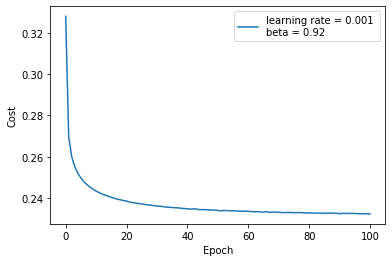

In [47]:
#Na wykresie poniżej widać, że koszt drastycznie maleje już po 20 iteracjach. Potem dokładność predykcji już niewiele wzrasta.
#Około 30 iteracji to moim zdaniem dobry kompromis pomiędzy czasem uczenia, a dokładnością.
x = np.arange(0, len(logistic.cost_))
y = logistic.cost_
plt.plot(x, y, label='learning rate = {:.3f} \nbeta = {:.2f}'.format(1e-3, 0.92))
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.show()

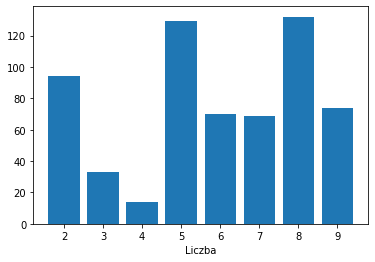

In [59]:
#Na poniższym wykresie widać, że najwięcej pomyłek popełniono przy klasyfikowaniu liczb 5 oraz 8.
wrong_predictions = []
for i, (y_t, y_p) in enumerate(zip(y_test_prime, y_pred)):
    if y_t != y_p:
        wrong_predictions.append(y_test[i])
number, count = np.unique(wrong_predictions, return_counts=True)
plt.bar(number, count)
plt.xlabel('Liczba')
plt.show()

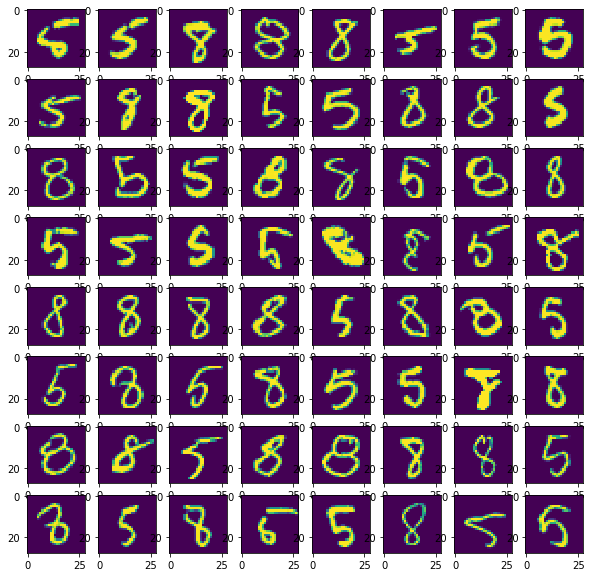

In [115]:
#Po wyświetleniu 64 źle sklasyfikowanych liczb 5 oraz 8 można zauważyć, że wiele z nich jest napisana dość niestarannie.
#Dodatkowo 8 i 5 są do siebie mocno zbliżone wyglądem w piśmie odręcznym. Uważam, że obie te rzeczy były przyczyną tak dużej
#liczby źle sklasyfikowanych przypadków.
pos = 1
plt.figure(figsize=[10, 10])
for i, (y_t, y_p) in enumerate(zip(y_test_prime, y_pred)):
    if y_t != y_p:
        if y_test[i] == 5 or y_test[i] == 8:
            plt.subplot(8, 8, pos)
            plt.imshow(X_test[i].reshape((28, 28)))
            pos += 1
            if pos == 65:
                break

# Podsumowanie

Zaimplementowany przeze mnie model regresji logistycznej poradził sobie całkiem dobrze z klasyfikacją liczb pierwszych bazując na zbiorze MNIST osiągając dokładność 0.922. Ewaluacja gradientów funkcji kosztu jest najbardziej czasochłonną operacją, dodatkowo spowolnioną przez algorytm SGD, w którym ta ewaluacja jest przeprowadzana na każdej próbce. Wszystkie hiperparametry (poza epochs i decay_rate, które są ze sobą wzajemnie powiązane poprzez relację decay_rate = 1 / epochs oraz parametrem regularyzacji, o czym później) zostały dobrane zautomatyzowaną metodą prób i błędów, co nie jest najbardziej wydajną metodą, ale bez dostępu do narzędzi z np. sklearn, była dość efektywnym substytutem. W celu skrócenia czasu szukania najlepszych hiperparametrów, używałem jedynie 25% zbioru danych uczących, co nie odbiło się na dokładności modelu w widoczny sposób. Pominąłem przeszukiwanie pod kątem parametru regularyzacji L2, gdyż, po uprzednim sprawdzeniu, zauważyłem, że nie ma widocznego wpływu na dokładność. Wszelkie obliczenia związane z funkcją kosztu oraz jej różniczkowaniem przeprowadziłem na kartce papieru, co nie stanowiło większego problemu, gdyż takimi zadaniami zajmuję się w wolnej chwili hobbystycznie :)